# Project - Computer Vision - 1

**DOMAIN:** Botanical research<br>

**• PROJECT OBJECTIVE:** University’s management require an automation which can create a classi ier capable of determining a plant's species from a photo

**Steps and tasks:**
1. Import the data. Analyse the dimensions of the data. Visualise the data.

In [1]:
from PIL import Image
import os
from joblib import Parallel, delayed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Concatenate, InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, regularizers
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import load_model
from tensorflow.keras import backend
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

import numpy as np
import pandas as pd
import datetime, os, pickle
import matplotlib.pyplot as plt
tf.test.gpu_device_name()

2022-06-06 19:30:28.041769: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-06 19:30:28.172918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 19:30:28.268852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 19:30:28.269181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

'/device:GPU:0'

lets review the image dimensions in the train data

In [2]:
%%time
def sizes(impath):
    im = Image.open(impath)
    return(im.size)

def inFolders(fldpath):
    imsizes = Parallel(n_jobs=-1,pre_dispatch='1.5*n_jobs',verbose=0
                        )(delayed(sizes
                                 )(fldpath+"/"+imgname
                                  ) for imgname in os.listdir(fldpath))
    return imsizes

dims = Parallel(n_jobs=2,pre_dispatch='1.5*n_jobs',verbose=0
               )(delayed(inFolders
                        )("./train/"+folder) for folder in os.listdir("./train"))

CPU times: user 27.4 ms, sys: 64.5 ms, total: 91.9 ms
Wall time: 626 ms


In [3]:
dimdata = []
for species in dims:
    dimdata.extend(species)
print("total number of images in training data: %d"%len(dimdata))

total number of images in training data: 4767


In [4]:
pxls = [tf.multiply(h,w).numpy() for h,w in dimdata ]
h = [h for h,w in dimdata]
w = [w for h,w in dimdata]
print("dims of largest image: ",dimdata[tf.argmax(pxls)])
print("dims of widest image: ",dimdata[tf.argmax(w)])
print("dims of tallest image: ",dimdata[tf.argmax(h)])
print("dims of smallest image: ",dimdata[tf.argmin(pxls)])
print("dims of leanest image: ",dimdata[tf.argmin(w)])
print("dims of shortest image: ",dimdata[tf.argmin(h)])

dims of largest image:  (3991, 3457)
dims of widest image:  (3991, 3457)
dims of tallest image:  (3991, 3457)
dims of smallest image:  (49, 49)
dims of leanest image:  (49, 49)
dims of shortest image:  (49, 49)


2022-04-10 13:50:56.225377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 13:50:56.225686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 13:50:56.225896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 13:50:56.226513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 13:50:56.226748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Lets visualise 5 images randomly from each

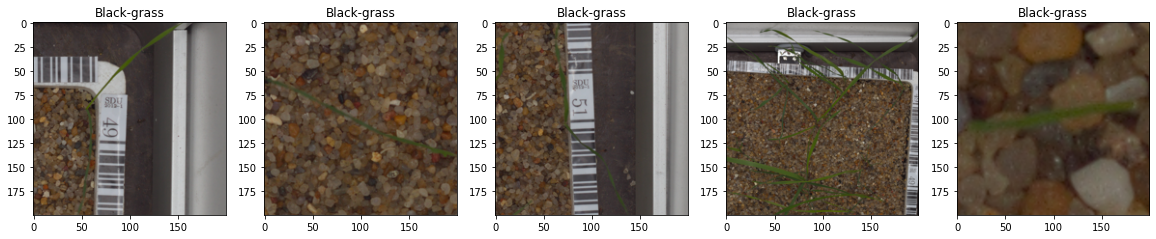

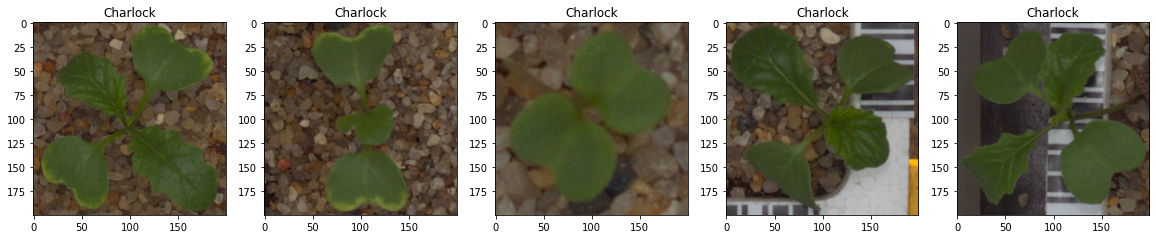

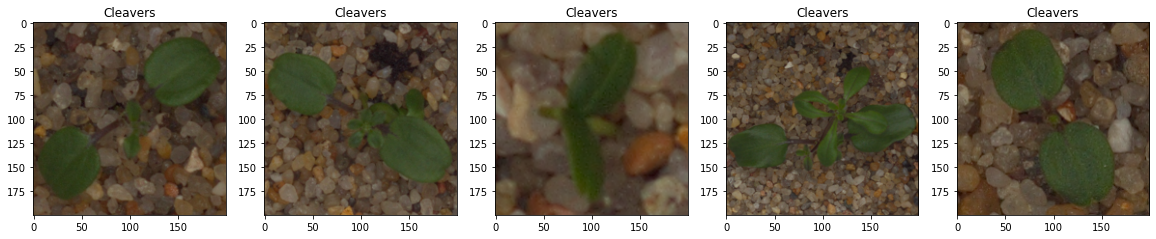

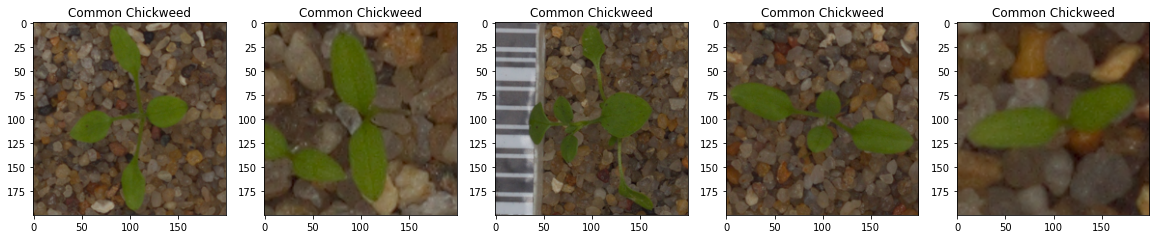

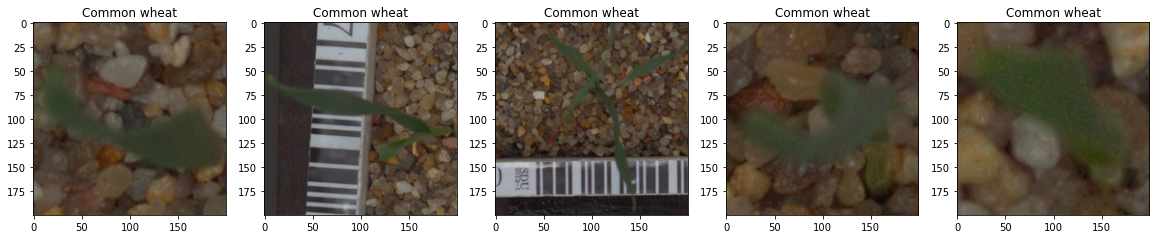

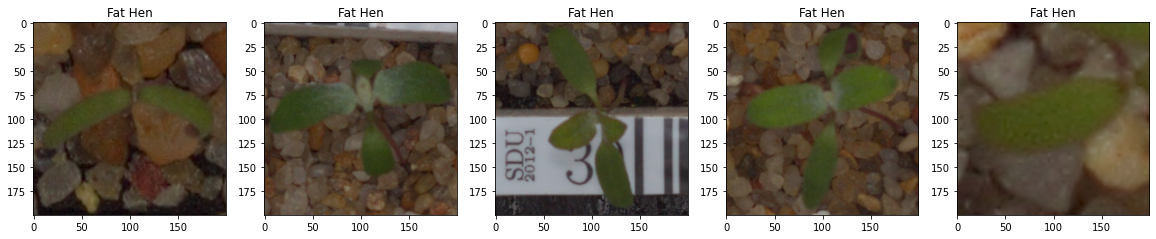

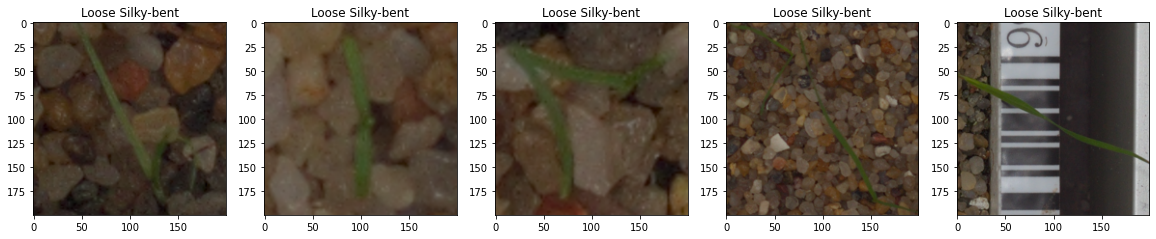

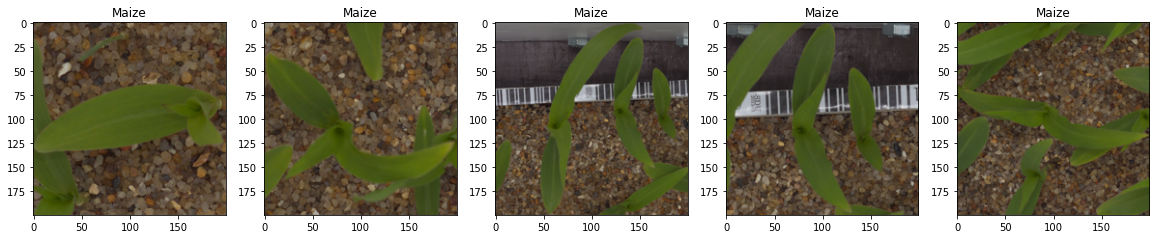

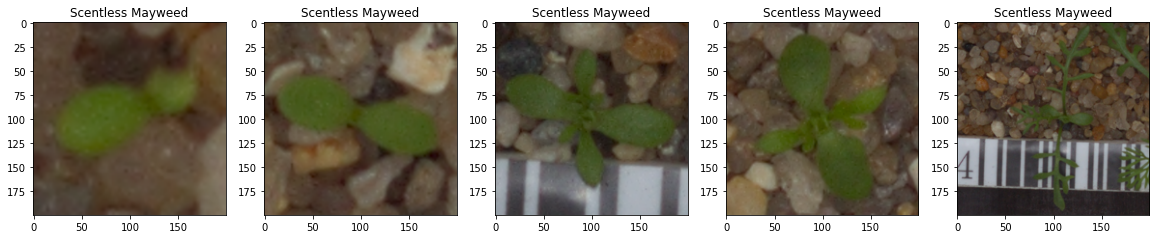

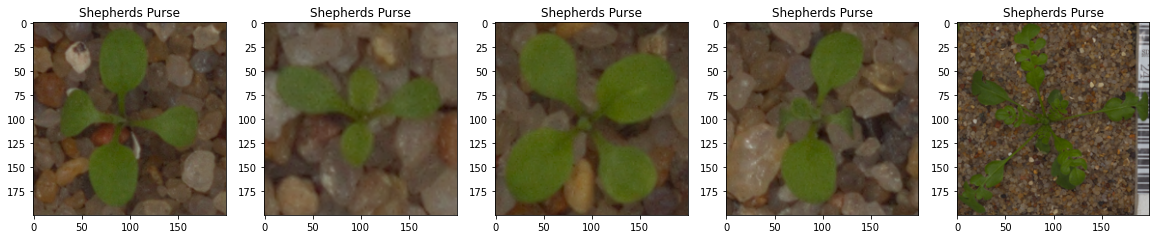

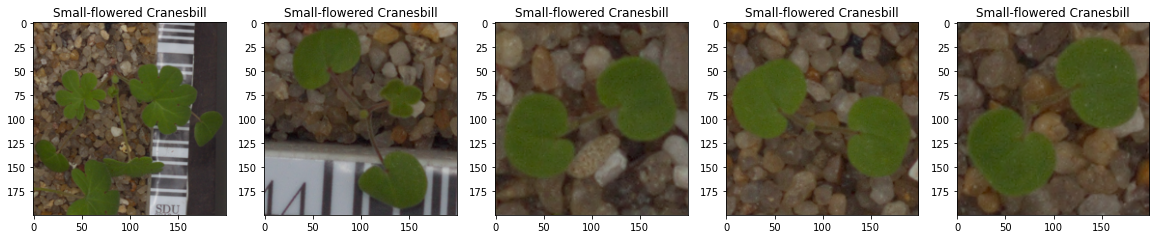

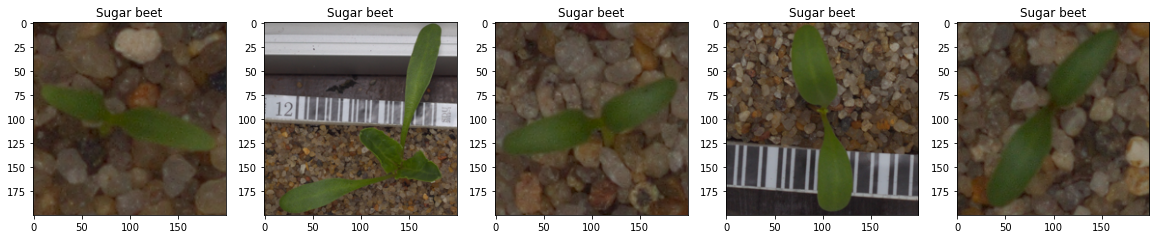

In [5]:
for cat in os.listdir("./train"):
    plt.figure(figsize=(20,50))
    for i,img in enumerate(np.random.choice(os.listdir('./train/'+cat),5,replace=False)):
        img = Image.open('./train/'+cat+'/'+img).resize((200,200))
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.title(cat)
    plt.show()

**Steps and tasks:**<br>
2. Design, train tune and test the best AIML image classifier model using:<br>
• Supervised learning algorithms<br>
• Neural networks<br>
• CNN<br>

In [6]:
# irrespective of the model to be deployed, the models need consistent input dimensions
# hence set up data preprocessing mechanism
# the least dimensions found in the dataset was 49x49
# using imagedatagenerator to produce augmented images of dimensions 49x49
datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20,
                                   shear_range = 0.2, zoom_range = 0.2,
                                   width_shift_range = 0.1, height_shift_range = 0.1,
                                   horizontal_flip = True, vertical_flip = True,
                                   data_format = 'channels_last', validation_split = 0.1)

trainset = datagen.flow_from_directory('./train', target_size = (49,49), 
                                                  batch_size=32, subset='training',class_mode = 'categorical')

validationset = datagen.flow_from_directory('./train', target_size = (49,49), 
                                                  batch_size=32, subset='validation',class_mode = 'categorical')

# resize prediction image to similar size
test_datagen = ImageDataGenerator(rescale = 1./255)
img = Image.open('Predict.png')
testset = test_datagen.flow(tf.expand_dims(img.resize((49,49)),axis=0))

Found 4294 images belonging to 12 classes.
Found 473 images belonging to 12 classes.


In [7]:
fpath = "/media/bharat/Barracuda/B S P/Anaconda_workspace/GLAIML_course/09 - ComputerVision/3 - week Project/logs/"

### Transfer Learning from Resnet50

Trusting in the capabilities of Resnet50, lets perform a transfer learning from the Resnet50 CNN<br>
later lets build customized Neural Networks & a Machine learning algorithm, in an attempt to acheive the accuracy of CNN based transfer learning technique.

lets functionally connect the resnet output to a series of Dense & BatchNormalisation layers before connecting to a softmax layer via a Dropout<br>
also lets take a parallel stream of a slightly different heirarchy and concat both the outputs before the softmax<br>
to choose the best combination of architecture, lets tryout few epochs<br>
we would also combine the hyperparameter search on the go<br>

In [2]:
# create parameter options
nNodes = [1024,512,256,128,64]
nBranches = hp.HParam('Branches',hp.Discrete([1,2,3,4]))
dropOut = hp.HParam('DropOutRatio',hp.Discrete([0.2,0.4,0.6,0.8]))
lr = hp.HParam('LearningRate',hp.Discrete([1e-2,1e-3,1e-4]))
skip = hp.HParam('skipConnection',hp.Discrete([True,False]))
dRate = hp.HParam('DecayRate',hp.Discrete([0.1,0.3,0.5]))

# define the hyper parameter of the architecture
branchNodes = []
for branch in nBranches.domain.values: #HParam Branches
    nodeList = []
    for i in range(branch):
        nodeList.extend([nNodes[i]]) #HParam nodes
    branchNodes.append(nodeList)

# create a grid of hyperparameters
pgrid = [[nNode,dropout,lrt,skp,dr]
         for nNode in branchNodes
         for dropout in dropOut.domain.values
         for lrt in lr.domain.values
         for skp in skip.domain.values
         for dr in dRate.domain.values
        ]

print("number of grid points: ",len(pgrid))

number of grid points:  288


In [4]:
pgrid[134]

[[1024, 512], 0.8, 0.001, False, 0.5]

In [56]:
gridRuns = [] # reset local log

# read the tuning log (if any)
file = open(fpath+"CNN_tuning.bhar",'rb')
read = True
while read:
    try:
        gridRuns.append(pickle.load(file))
    except:
        read = False
file.close()

if len(gridRuns)>0:
    grids = [i[:-3] for i in gridRuns]
else:
    grids = []

# delete pre-evaluated gridpoints (if any)
for gp in grids: 
    try:
        pgrid.remove(gp)
    except:
        pass

print("grid points remaining: ",len(pgrid))

grid points remaining:  255


In [30]:
# customised learning rate scheduler
# considering slope of validation loss
class lossGradientLR(tf.keras.callbacks.Callback):
    def __init__(self,initial_learning_rate,patience,factor,verbose=False):
        super(lossGradientLR, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.patience = patience
        self.factor = factor
        self.verbose=verbose
        self.loss=[]
        self.lr=[initial_learning_rate]
        self.lastAdjust = 0
        
    def Gradient_schedule(self,epoch):
        flag1 = False
        flag1 = (epoch-self.lastAdjust)>self.patience # min epoch before adjust
        
        flag2 = False
        try:
            flag2 = (self.loss[-1]-self.loss[-2])>0 and (self.loss[-2]-self.loss[-3])>0
            # if two continuous epochs have increasing validation loss
        except:
            pass
        
        # slope of validation loss
        lossGrad = (self.loss[-1]-self.loss[self.lastAdjust])
        lossGrad/= len(self.loss[self.lastAdjust:])
        
        # if slope of validation loss not descending at -0.25 slope or flag2
        if (flag1 and lossGrad>-0.25) or (flag2):
            self.lr.append(max(self.lr[-1]*self.factor,1e-7)) #min lr 1e-7
            self.lastAdjust = epoch # update last adjust epoch
        
        if self.verbose:
            print("\nslopeOfLoss:%.2f"%lossGrad," @ epoch:%d"%epoch, "---- learning_rate:",self.lr[-1])
        
    def on_epoch_end(self,epoch,logs={}):
        """on end of each epoch"""
        # fetch validation loss
        self.loss.append(logs.get('val_loss'))
        #invoke learning rate calculator
        self.Gradient_schedule(epoch)
        
    def on_epoch_begin(self,epoch,logs={}):
        """beginning of each epoch"""
        # update model learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr[-1])

In [11]:
# report learning rate to tensorboard
# due to custom lr_scheduler
class LRTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, log_dir, **kwargs):
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({'learning_rate': backend.eval(self.model.optimizer.learning_rate)})
        super().on_epoch_end(epoch, logs)

In [35]:
%%time
# perform random grid search
epochs = 20
nSearch = 5

for niter,gp in enumerate(np.random.randint(0,len(pgrid),nSearch)):
    
    print("grid :",len(gridRuns)+1)
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # attempting transfer learning from ResNet50
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(49,49,3), pooling='max')
    
    _nBranch = len(pgrid[gp][0])
    _nodes = pgrid[gp][0] # HParam nNodes
    
    # create model architecture
    X = []
    # First: Flatten layer deriving inputs from resnet
    flat = Flatten()(resnet.output)
    # Second: parallel branches
    for i in range(_nBranch): # HParam Branches
        branch = Dense(_nodes[i],activation='relu')(flat)
        branch = BatchNormalization()(branch)
        X.extend([branch])
    # Optional skip connection bypass to branches
    if pgrid[gp][3]:
        X.extend([flat]) # HParam SkipConnection
    # Third: Concat all above branches and skip connection
    x = Concatenate()(X)
    # Fourth : dense 36 nodes
    x = Dense(36, activation="relu")(x)
    # Fifth : Dropout HParam
    x = Dropout(pgrid[gp][1])(x) # HParam Dropout 
    # Final & Sixth : Softmax classification result
    x = Dense(12, activation='softmax')(x)
    
    model = Model(resnet.input,x)
    model.trainable=True
    resnetlayers=len(resnet.layers)
    for i,layer in enumerate(model.layers):
        if i<resnetlayers:
            layer.trainable = False # freeze resnet layers
        else:
            layer.trainable=True # unfreeze custom layers
    
    mname = "htuneCNN_%03d_"%(len(gridRuns)+1) + datetime.datetime.now().strftime("%d%b_%I%M%P")
    
    # create tensorboard logs & callbacks
    logdir = os.path.join("logs", mname )
    tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    # initiate learning rate reporter
    lReport = LRTensorBoard(logdir)

    verbose = max(0,1-niter) # chat once, then go silent
    
    # initiate learning rate callback
    lr_schedule = lossGradientLR(pgrid[gp][2],# HParam learning rate
                                 patience=5,verbose=bool(verbose),
                                 factor=pgrid[gp][4])# HParam decayRate
    
    # define optimsers and compile the model
    optim = optimizers.RMSprop(learning_rate=pgrid[gp][2],# HParam learning rate
                               rho=0.9, momentum=0.1, epsilon=1e-07)
    model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    # summarise the HParams
    hparams = dict(nBranches=len(pgrid[gp][0]),
                   skip=pgrid[gp][3],
                   dropOut=pgrid[gp][1],
                   lr=pgrid[gp][2],
                   dRate=pgrid[gp][4]
                  )
    
    # callback for HParam writting
    hypertune = hp.KerasCallback(logdir,hparams)
    
    # model fitting
    with tf.device('/device:GPU:0'):
        logger = model.fit(trainset, epochs = epochs,
                           verbose = verbose, steps_per_epoch = 10, # limited learning for hypertuning
                           validation_data = validationset, validation_steps = 5,
                           callbacks=[tensorboard,lr_schedule,lReport,hypertune])
    
    # obtain peak results
    p_acc,p_epoch = np.max(logger.history.get('val_accuracy')),np.argmax(logger.history.get('val_accuracy'))
    
    # summarise hparams with results
    with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
        hp.hparams(hparams)
        accuracy = p_acc
        tf.summary.scalar('accuracy',accuracy,step=1)
    
    # log the results
    storage = []
    storage.extend(pgrid[gp])
    storage.extend([p_acc,p_epoch])
    storage.extend([mname])
    
    file = open(fpath+"CNN_tuning.bhar",'ab')
    pickle.dump(storage,file)
    file.close()
    
    gridRuns = [] # reset local log

    # read the logs
    file = open(fpath+"CNN_tuning.bhar",'rb')
    read = True
    while read:
        try:
            gridRuns.append(pickle.load(file))
        except:
            read = False
    file.close()

grid : 31
Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 2.9930 - accuracy: 0.1094
slopeOfLoss:0.00  @ epoch:0 ---- learning_rate: 0.001
10/10 [==============================] - 13s 1s/step - loss: 2.9930 - accuracy: 0.1094 - val_loss: 2.7477 - val_accuracy: 0.1250 - learning_rate: 0.0010
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 2.7742 - accuracy: 0.1469
slopeOfLoss:-0.07  @ epoch:1 ---- learning_rate: 0.001
10/10 [==============================] - 9s 933ms/step - loss: 2.7742 - accuracy: 0.1469 - val_loss: 2.6022 - val_accuracy: 0.1187 - learning_rate: 0.0010
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 2.6437 - accuracy: 0.0969
slopeOfLoss:-0.09  @ epoch:2 ---- learning_rate: 0.001
10/10 [==============================] - 8s 812ms/step - loss: 2.6437 - accuracy: 0.0969 - val_loss: 2.4743 - val_accuracy: 0.1375 - learning_rate: 0.0010
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 2.5371 - accu

In [57]:
# display the log in a convenient pandas frame
cols = ["nNodes","DropoutRatio","LearningRate","SkipConnection","DecayRate","PeakAccuracy","PeakEpoch","ModelName"]
display(pd.DataFrame(gridRuns,columns=cols).sort_values(by="PeakAccuracy",ascending=False).head())

nNodes  DropoutRatio  LearningRate  SkipConnection  \
17  [1024, 512, 256, 128]           0.8         0.001            True   
10  [1024, 512, 256, 128]           0.2         0.001            True   
33       [1024, 512, 256]           0.6         0.001            True   
4        [1024, 512, 256]           0.8         0.001            True   
14       [1024, 512, 256]           0.8         0.010            True   

    DecayRate  PeakAccuracy  PeakEpoch                  ModelName  
17        0.3       0.18750         13  htuneCNN_018_10Apr_0253pm  
10        0.5       0.18750         16  htuneCNN_011_10Apr_0235pm  
33        0.1       0.18125         18  htuneCNN_034_10Apr_0348pm  
4         0.1       0.18125         10  htuneCNN_005_10Apr_0218pm  
14        0.3       0.17500         13  htuneCNN_015_10Apr_0245pm

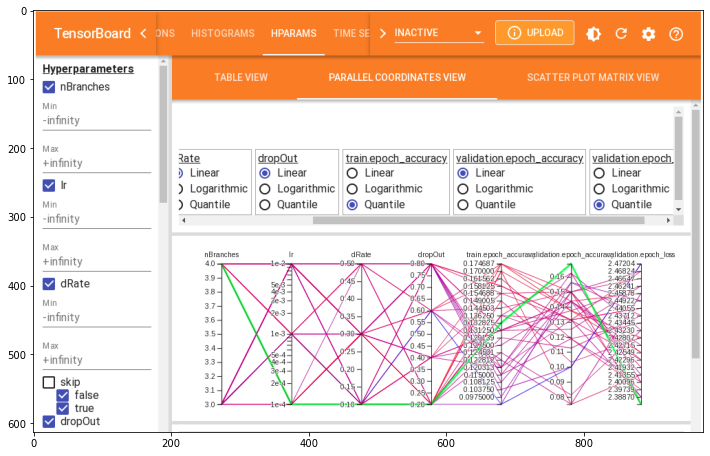

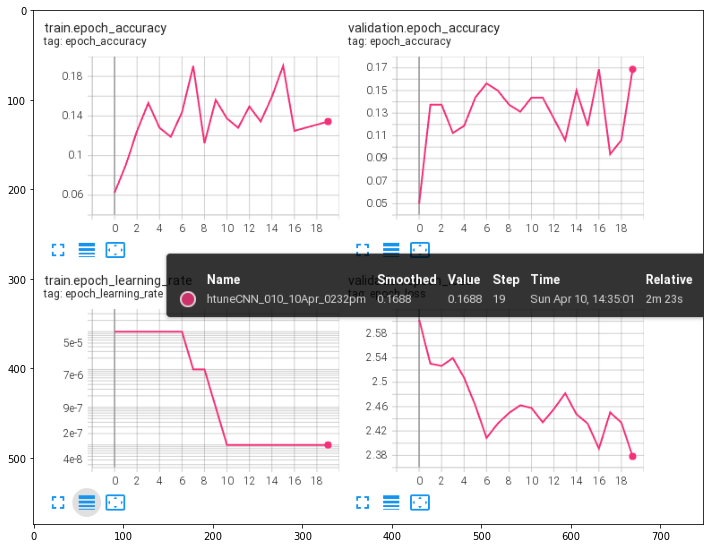

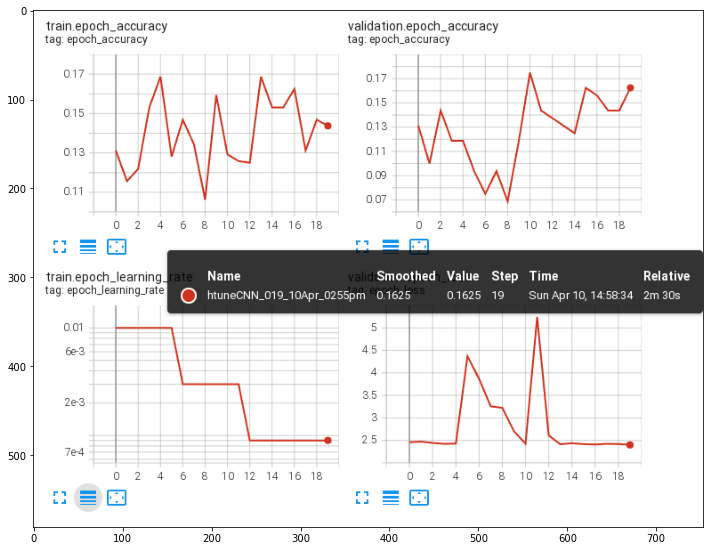

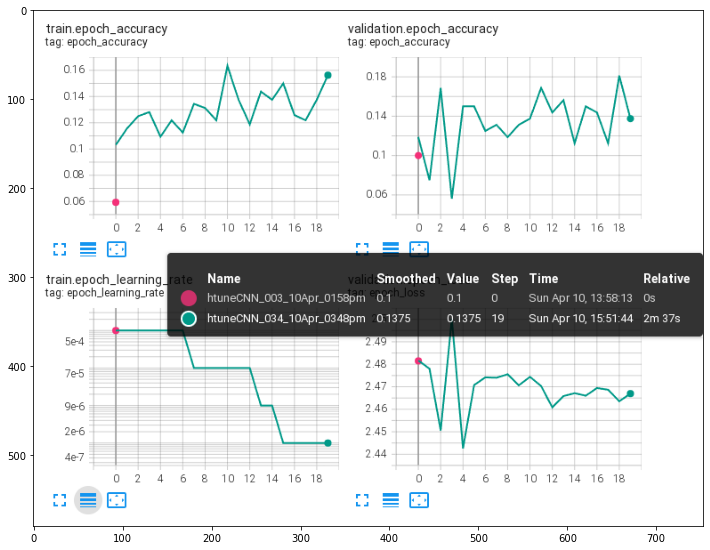

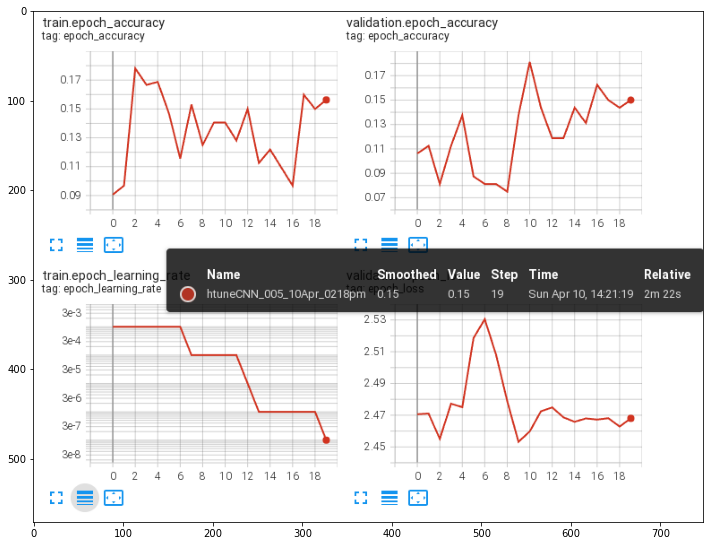

In [48]:
# review & selection of the best model from tensorflow
plt.figure(figsize=(12,18));
plt.imshow(plt.imread('htuneCNN_log.png'));
plt.figure(figsize=(12,18));
plt.imshow(plt.imread('htuneCNN_bestmodel_1.png'));
plt.figure(figsize=(12,18));
plt.imshow(plt.imread('htuneCNN_bestmodel_2.png'));
plt.figure(figsize=(12,18));
plt.imshow(plt.imread('htuneCNN_bestmodel_3.png'));
plt.figure(figsize=(12,18));
plt.imshow(plt.imread('htuneCNN_bestmodel_4.png'));

In [83]:
# chosen top grids
grids[4],grids[9],grids[18],grids[33]

([[1024, 512, 256], 0.8, 0.001, True, 0.1],
 [[1024, 512, 256, 128], 0.2, 0.0001, True, 0.1],
 [[1024, 512, 256], 0.2, 0.01, True, 0.3],
 [[1024, 512, 256], 0.6, 0.001, True, 0.1])

In [82]:
%%time
# lets put the 4 top model architectures to full dataset
refine = [grids[4],grids[9],grids[18],grids[33]]

epochs = 50

for niter,gp in enumerate(refine):
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # attempting transfer learning from ResNet50
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(49,49,3), pooling='max')
    
    _nBranch = len(gp[0])
    _nodes = gp[0] # HParam nNodes
    
    # create model architecture
    X = []
    # First: Flatten layer deriving inputs from resnet
    flat = Flatten()(resnet.output)
    # Second: parallel branches
    for i in range(_nBranch): # HParam Branches
        branch = Dense(_nodes[i],activation='relu')(flat)
        branch = BatchNormalization()(branch)
        X.extend([branch])
    # Optional skip connection bypass to branches
    if gp[3]:
        X.extend([flat]) # HParam SkipConnection
    # Third: Concat all above branches and skip connection
    x = Concatenate()(X)
    # Fourth : dense 36 nodes
    x = Dense(36, activation="relu")(x)
    # Fifth : Dropout HParam
    x = Dropout(gp[1])(x) # HParam Dropout 
    # Final & Sixth : Softmax classification result
    x = Dense(12, activation='softmax')(x)
    
    model = Model(resnet.input,x)
    model.trainable=True
    resnetlayers=len(resnet.layers)
    for i,layer in enumerate(model.layers):
        if i<resnetlayers:
            layer.trainable = False # freeze resnet layers
        else:
            layer.trainable=True # unfreeze custom layers
    
    mname = "refineCNN_%03d_"%(niter+1) + datetime.datetime.now().strftime("%d%b_%I%M%P")
    
    # create tensorboard logs & callbacks
    logdir = os.path.join("logs", mname )
    tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    # initiate learning rate reporter
    lReport = LRTensorBoard(logdir)

    verbose = 0 #silent
    
    # save best model weights
    saveFile = 'logs/'+mname+'_weights.{epoch:02d}-{val_accuracy:.2f}.h5'
    saveBest = tf.keras.callbacks.ModelCheckpoint(filepath=saveFile,monitor='val_accuracy',
                                              mode='max',save_best_only=True)
    
    # early stop callback
    earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 min_delta=0.01,patience=15,restore_best_weights=True)
    
    # initiate learning rate callback
    lr_schedule = lossGradientLR(gp[2],# HParam learning rate
                                 patience=5,verbose=bool(verbose),
                                 factor=gp[4])# HParam decayRate
    
    # define optimsers and compile the model
    optim = optimizers.RMSprop(learning_rate=gp[2],# HParam learning rate
                               rho=0.9, momentum=0.1, epsilon=1e-07)
    model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    # model fitting
    with tf.device('/device:GPU:0'):
        logger = model.fit(trainset, epochs = epochs, verbose = verbose, 
                           validation_data = validationset,
                           callbacks=[tensorboard,lr_schedule,lReport,saveBest,earlyStop])
    
    # obtain peak results
    p_acc,p_epoch = np.max(logger.history.get('val_accuracy')),np.argmax(logger.history.get('val_accuracy'))
    
    # restore the best weights
    savefiles=[]
    # search the saveFiles
    for root, dirs, files in os.walk('./logs'):
        for file in files:
            if file.startswith(mname+'_weights') and file.endswith('.h5'):
                savefiles.append(file)
    # choose the best epoch (latest saveBest)
    bestweights = sorted(savefiles,reverse=True)[0]
    # load the weights
    model.load_weights('./logs/'+bestweights)
    
    # save the model
    model.save('./'+mname+'.h5')
    model.save_weights('./'+mname+'_weights.h5')
    
    # log the results
    storage = []
    storage.extend(gp)
    storage.extend([p_acc,p_epoch])
    storage.extend([mname])
    
    file = open(fpath+"CNN_tuning.bhar",'ab')
    pickle.dump(storage,file)
    file.close()
    
    gridRuns = [] # reset local log

    # read the logs
    file = open(fpath+"CNN_tuning.bhar",'rb')
    read = True
    while read:
        try:
            gridRuns.append(pickle.load(file))
        except:
            read = False
    file.close()

2022-04-10 17:05:23.446733: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


CPU times: user 1h 16min 28s, sys: 5min 23s, total: 1h 21min 52s
Wall time: 1h 3min 46s


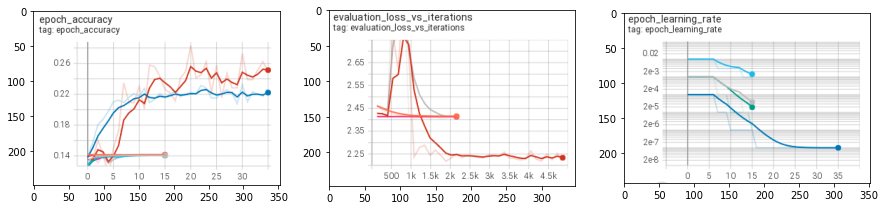

In [91]:
# review for the 4 model performances
plt.figure(figsize=(15,45));
plt.subplot(131);
plt.imshow(plt.imread('refine_accuracy.png'));
plt.subplot(132);
plt.imshow(plt.imread('refine_loss.png'));
plt.subplot(133);
plt.imshow(plt.imread('refine_lr.png'));

only refineCNN_002 with grid[9] sustained the iterations<br>
lets try to unfreeze the resnet layers and relearn the model

In [93]:
# prepare for further training
# Random consistency seed
np.random.seed(129)
tf.random.set_seed(129)

# warm start / transfer learning
refineCNN = load_model('./refineCNN_002_10Apr_0516pm.h5')
refineCNN.load_weights('./refineCNN_002_10Apr_0516pm_weights.h5')

In [104]:
refineCNN.trainable=True
firstTrainLayer=None
for i,layer in enumerate(model.layers):
    if layer.name.startswith('conv5'): # unfreeze 5th convolutional group
        if firstTrainLayer == None:
            firstTrainLayer=i
    try:
        if i>=firstTrainLayer:
            layer.trainable=True
    except:
        layer.trainable=False

In [106]:
for i,layer in enumerate(model.layers):
    print("%03d"%i," %-25s"%layer.name,"---",layer.trainable)

000  input_45                  --- False
001  conv1_pad                 --- False
002  conv1_conv                --- False
003  conv1_bn                  --- False
004  conv1_relu                --- False
005  pool1_pad                 --- False
006  pool1_pool                --- False
007  conv2_block1_1_conv       --- False
008  conv2_block1_1_bn         --- False
009  conv2_block1_1_relu       --- False
010  conv2_block1_2_conv       --- False
011  conv2_block1_2_bn         --- False
012  conv2_block1_2_relu       --- False
013  conv2_block1_0_conv       --- False
014  conv2_block1_3_conv       --- False
015  conv2_block1_0_bn         --- False
016  conv2_block1_3_bn         --- False
017  conv2_block1_add          --- False
018  conv2_block1_out          --- False
019  conv2_block2_1_conv       --- False
020  conv2_block2_1_bn         --- False
021  conv2_block2_1_relu       --- False
022  conv2_block2_2_conv       --- False
023  conv2_block2_2_bn         --- False
024  conv2_block

In [107]:
epochs = 100
gp = grids[9]

mname = "unfreezeCNN_001_" + datetime.datetime.now().strftime("%d%b_%I%M%P")

# create tensorboard logs & callbacks
logdir = os.path.join("logs", mname )
tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# initiate learning rate reporter
lReport = LRTensorBoard(logdir)

verbose = 0 #silent

# save best model weights
saveFile = 'logs/'+mname+'_weights.{epoch:02d}-{val_accuracy:.2f}.h5'
saveBest = tf.keras.callbacks.ModelCheckpoint(filepath=saveFile,monitor='val_accuracy',
                                              mode='max',save_best_only=True)

# early stop callback
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                             min_delta=0.01,patience=15,restore_best_weights=True)

# initiate learning rate callback
lr_schedule = lossGradientLR(gp[2],# HParam learning rate
                             patience=5,verbose=bool(verbose),
                             factor=gp[4])# HParam decayRate

# define optimsers and compile the model
optim = optimizers.RMSprop(learning_rate=gp[2],# HParam learning rate
                           rho=0.9, momentum=0.1, epsilon=1e-07)
refineCNN.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# model fitting
with tf.device('/device:GPU:0'):
    logger = refineCNN.fit(trainset, epochs = epochs, verbose = verbose, 
                       validation_data = validationset,
                       callbacks=[tensorboard,lr_schedule,lReport,saveBest,earlyStop])

# obtain peak results
p_acc,p_epoch = np.max(logger.history.get('val_accuracy')),np.argmax(logger.history.get('val_accuracy'))

# restore the best weights
savefiles=[]
# search the saveFiles
for root, dirs, files in os.walk('./logs'):
    for file in files:
        if file.startswith(mname+'_weights') and file.endswith('.h5'):
            savefiles.append(file)
# choose the best epoch (latest saveBest)
bestweights = sorted(savefiles,reverse=True)[0]
# load the weights
refineCNN.load_weights('./logs/'+bestweights)

# save the model
refineCNN.save('./unfreezeCNN_001_.h5')
refineCNN.save_weights('./unfreezeCNN_001_weights.h5')

# log the results
storage = []
storage.extend(gp)
storage.extend([p_acc,p_epoch])
storage.extend([mname])

file = open(fpath+"CNN_tuning.bhar",'ab')
pickle.dump(storage,file)
file.close()

gridRuns = [] # reset local log

# read the logs
file = open(fpath+"CNN_tuning.bhar",'rb')
read = True
while read:
    try:
        gridRuns.append(pickle.load(file))
    except:
        read = False
file.close()

2022-04-10 18:55:46.145314: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-10 18:55:46.167149: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-10 18:55:46.335716: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-10 18:55:46.357768: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

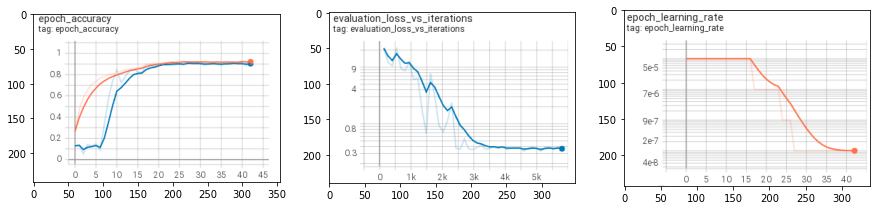

In [108]:
# review for the Conv5 unFreezed model
plt.figure(figsize=(15,45));
plt.subplot(131);
plt.imshow(plt.imread('unFreeze_accuracy.png'));
plt.subplot(132);
plt.imshow(plt.imread('unFreeze_loss.png'));
plt.subplot(133);
plt.imshow(plt.imread('unFreeze_lr.png'));

the unfreezeCNN_001 has achieved remarkable 0.92 accuracy<br>
lets put it to prediction of the given image

2022-04-10 19:42:31.156728: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


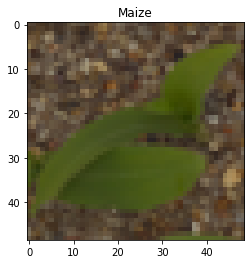

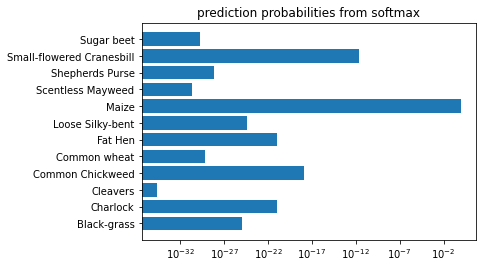

In [109]:
unFreezeCNN = load_model('./unfreezeCNN_001_.h5')
unFreezeCNN.load_weights('./unfreezeCNN_001_weights.h5')
# predict for the predict.png loaded via ImageDataGenerator as testset
prediction = unFreezeCNN.predict(testset)
# process the softmax output
classIndex = np.argmax(prediction>0.5)
seedling = list(trainset.class_indices.keys())[classIndex]
# display the result and image
plt.figure();
plt.title(seedling);
plt.imshow(testset.next()[0]);
plt.figure();
plt.title('prediction probabilities from softmax');
plt.barh(list(trainset.class_indices.keys()),prediction[0],log=True);

the Resnet50 based CNN have predicted the test image correctly<br>

### Artificial Neural Networks model

lets build a few neural network modelling functions that will build, learn, evaluate

In [111]:
# lets create parameter gridpoints
hidden_layers = np.arange(2,6,1)
hidden_neurons = np.arange(50,500,50)
learning_rates = [1e-3,1e-4,1e-5]
Lambdas = [0.25,0.5,0.75]
dos = np.arange(0.2,0.7,0.1)

pgrid = [[hl,hn,lr,lm,do] 
           for hl in hidden_layers
           for hn in hidden_neurons
           for lr in learning_rates
           for lm in Lambdas
           for do in dos]

print("number of grid points: ",len(pgrid))

number of grid points:  1620


In [114]:
gridRuns = [] # reset local log

# read the tuning log (if any)
file = open(fpath+"NN_tuning.bhar",'rb')
read = True
while read:
    try:
        gridRuns.append(pickle.load(file))
    except:
        read = False
file.close()

if len(gridRuns)>0:
    grids = [i[:-3] for i in gridRuns]
else:
    grids = []

# delete pre-evaluated gridpoints (if any)
for gp in grids: 
    try:
        pgrid.remove(gp)
    except:
        pass

print("grid points remaining: ",len(pgrid))

grid points remaining:  1557


In [115]:
%%time
# perform random grid search
epochs = 20
nSearch = 5
verbose = 0

for niter,gp in enumerate(np.random.randint(0,len(pgrid),nSearch)):
    
    print("grid :",len(gridRuns)+1)
    
    [hl,hln,lr,lmbda,do]=pgrid[gp]
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # Build a Sequential model
    NN = Sequential()
    NN.add(InputLayer(input_shape=(49,49,3)))
    NN.add(Flatten())
    init = tf.keras.initializers.GlorotNormal(seed=129)
    NN.add(Dense(hln,activation='relu',
               kernel_initializer=init,
               kernel_regularizer=regularizers.l2(lmbda)))
    NN.add(BatchNormalization())
    for i in range(hl-1):
        NN.add(Dense(hln,activation='relu',
                        kernel_initializer=init,
                        kernel_regularizer=regularizers.l2(lmbda)))
        NN.add(BatchNormalization())
    NN.add(Dropout(do))
    NN.add(Dense(12, activation='softmax'))
    
    mname = "htuneNN_%03d_"%(len(gridRuns)+1) + datetime.datetime.now().strftime("%d%b_%I%M%P")
    
    # create tensorboard logs & callbacks
    logdir = os.path.join("logs", mname )
    tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    # initiate learning rate reporter
    lReport = LRTensorBoard(logdir)
    
    # initiate learning rate callback
    lr_schedule = lossGradientLR(lr,patience=5,verbose=bool(verbose),factor=0.25)
    
    # define optimsers and compile the model
    optim = optimizers.RMSprop(learning_rate=lr, rho=0.9, momentum=0.1, epsilon=1e-07)
    NN.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    # summarise the HParams
    hparams = dict(hiddenLayers=hl,
                   neuronsPerLayer=hln,
                   learningRate=lr,
                   Lambda=lmbda,
                   DropOut=do
                  )
    
    # callback for HParam writting
    hypertune = hp.KerasCallback(logdir,hparams)
    
    # model fitting
    with tf.device('/device:GPU:0'):
        logger = NN.fit(trainset, epochs = epochs,
                           verbose = 0, steps_per_epoch = 10, # limited learning for hypertuning
                           validation_data = validationset, validation_steps = 5,
                           callbacks=[tensorboard,hypertune,lr_schedule,lReport])
    
    # obtain peak results
    p_acc,p_epoch = np.max(logger.history.get('val_accuracy')),np.argmax(logger.history.get('val_accuracy'))
    
    # summarise hparams with results
    with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
        hp.hparams(hparams)
        accuracy = p_acc
        tf.summary.scalar('accuracy',accuracy,step=1)
    
    # log the results
    storage = []
    storage.extend(pgrid[gp])
    storage.extend([p_acc,p_epoch])
    storage.extend([mname])
    
    file = open(fpath+"NN_tuning.bhar",'ab')
    pickle.dump(storage,file)
    file.close()
    
    gridRuns = [] # reset local log

    # read the logs
    file = open(fpath+"NN_tuning.bhar",'rb')
    read = True
    while read:
        try:
            gridRuns.append(pickle.load(file))
        except:
            read = False
    file.close()
    
if len(gridRuns)>0:
    grids = [i[:-3] for i in gridRuns]
else:
    grids = []

# display the log in a convenient pandas frame
cols = ["HiddenLayers","NeuronsPerLayer","LearningRate","Lambda","DropOut","PeakAccuracy","PeakEpoch","ModelName"]
display(pd.DataFrame(gridRuns,columns=cols).sort_values(by="PeakAccuracy",ascending=False).head())

grid : 72
grid : 73
grid : 74
grid : 75
grid : 76


HiddenLayers  NeuronsPerLayer  LearningRate  Lambda  DropOut  \
65             5              150        0.0001    0.25      0.3   
70             2              400        0.0001    0.25      0.6   
64             5              150        0.0001    0.25      0.3   
21             3              200        0.0001    0.75      0.4   
29             4              100        0.0010    0.25      0.3   

    PeakAccuracy  PeakEpoch                 ModelName  
65      0.528541         95  trialNN_066_09Apr_0953pm  
70      0.287500          7  htuneNN_071_10Apr_0755pm  
64      0.270613         39  trialNN_065_09Apr_0940pm  
21      0.225000         16  htuneNN_022_09Apr_0806pm  
29      0.218750         10  htuneNN_030_09Apr_0821pm

CPU times: user 9min 19s, sys: 25.6 s, total: 9min 44s
Wall time: 8min 7s


In [119]:
# eliminate long run models from results
htuneNNresults = pd.DataFrame(gridRuns,columns=cols).sort_values(by="PeakAccuracy",ascending=False)
htuneNNresults.loc[htuneNNresults["PeakEpoch"]<=20].head()

HiddenLayers  NeuronsPerLayer  LearningRate  Lambda  DropOut  \
70             2              400        0.0001    0.25      0.6   
21             3              200        0.0001    0.75      0.4   
29             4              100        0.0010    0.25      0.3   
7              4              100        0.0010    0.25      0.5   
35             2              350        0.0010    0.50      0.2   

    PeakAccuracy  PeakEpoch                 ModelName  
70       0.28750          7  htuneNN_071_10Apr_0755pm  
21       0.22500         16  htuneNN_022_09Apr_0806pm  
29       0.21875         10  htuneNN_030_09Apr_0821pm  
7        0.21875         12  htuneNN_008_09Apr_0737pm  
35       0.21875          1  htuneNN_036_09Apr_0831pm

In [123]:
%%time
# trying out 
# more steps, more steps_per_epoch, full validation steps and learning rate decay
# with one of the best learner

epochs = 100
grid=grids[70]
[hl,hln,lr,lmbda,do]=grid

# Random consistency seed
np.random.seed(129)
tf.random.set_seed(129)

# Build a Sequential model
NN = Sequential()
NN.add(InputLayer(input_shape=(49,49,3)))
NN.add(Flatten())
init = tf.keras.initializers.GlorotNormal(seed=129)
NN.add(Dense(hln,activation='relu',
             kernel_initializer=init,
             kernel_regularizer=regularizers.l2(lmbda)))
NN.add(BatchNormalization())
for i in range(hl-1):
    NN.add(Dense(hln,activation='relu',
                 kernel_initializer=init,
                 kernel_regularizer=regularizers.l2(lmbda)))
    NN.add(BatchNormalization())
NN.add(Dropout(do))
NN.add(Dense(12, activation='softmax'))

mname = "refineNN_001_" + datetime.datetime.now().strftime("%d%b_%I%M%P")

# create tensorboard logs & callbacks
logdir = os.path.join("logs", mname )
tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# initiate learning rate reporter
lReport = LRTensorBoard(logdir)
    
# initiate learning rate callback
lr_schedule = lossGradientLR(lr,patience=5,verbose=bool(verbose),factor=0.2)

# define optimsers and compile the model
optim = optimizers.RMSprop(learning_rate=lr, rho=0.9, momentum=0.1, epsilon=1e-07)
NN.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# early stop callback
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                             min_delta=0.01,patience=15,restore_best_weights=True)

# save best model weights
saveFile = 'logs/'+mname+'_weights.{epoch:02d}-{val_accuracy:.2f}.h5'
saveBest = tf.keras.callbacks.ModelCheckpoint(filepath=saveFile,monitor='val_accuracy',
                                              mode='max',save_best_only=True)

# model fitting
with tf.device('/device:GPU:0'):
    logger = NN.fit(trainset, epochs = epochs,verbose = 0,
                    validation_data = validationset,
                    callbacks=[tensorboard,lr_schedule,lReport,earlyStop,saveBest])
    
# obtain peak results
p_acc,p_epoch = np.max(logger.history.get('val_accuracy')),np.argmax(logger.history.get('val_accuracy'))

# restore the best weights
savefiles=[]
# search the saveFiles
for root, dirs, files in os.walk('./logs'):
    for file in files:
        if file.startswith(mname+'_weights') and file.endswith('.h5'):
            savefiles.append(file)
# choose the best epoch (latest saveBest)
bestweights = sorted(savefiles,reverse=True)[0]
# load the weights
NN.load_weights('./logs/'+bestweights)

# save the model
NN.save('./refineNN_001.h5')
NN.save_weights('./refineNN_001_weights.h5')
    
# log the results
storage = []
storage.extend(grid)
storage.extend([p_acc,p_epoch])
storage.extend([mname])

file = open(fpath+"NN_tuning.bhar",'ab')
pickle.dump(storage,file)
file.close()

gridRuns = [] # reset local log

# read the logs
file = open(fpath+"NN_tuning.bhar",'rb')
read = True
while read:
    try:
        gridRuns.append(pickle.load(file))
    except:
        read = False
file.close()

if len(gridRuns)>0:
    grids = [i[:-3] for i in gridRuns]
else:
    grids = []

CPU times: user 50min 49s, sys: 1min, total: 51min 49s
Wall time: 49min 56s


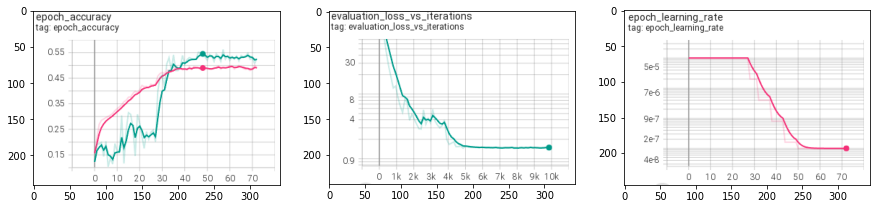

In [124]:
# review for the refineNN_001 model
plt.figure(figsize=(15,45));
plt.subplot(131);
plt.imshow(plt.imread('refineNN_1_accuracy.png'));
plt.subplot(132);
plt.imshow(plt.imread('refineNN_1_loss.png'));
plt.subplot(133);
plt.imshow(plt.imread('refineNN_1_lr.png'));

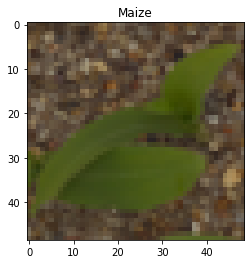

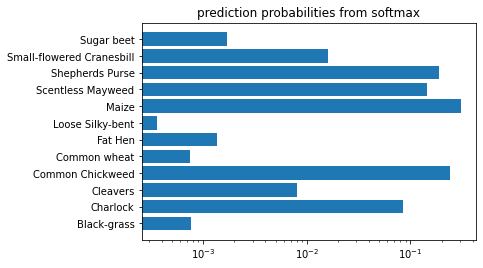

In [134]:
refineNN = load_model('./refineNN_001.h5')
refineNN.load_weights('./refineNN_001_weights.h5')
# predict for the predict.png loaded via ImageDataGenerator as testset
prediction = refineNN.predict(testset)
# process the softmax output
classIndex = np.argmax(prediction)
seedling = list(trainset.class_indices.keys())[classIndex]
# display the result and image
plt.figure();
plt.title(seedling);
plt.imshow(testset.next()[0]);
plt.figure();
plt.title('prediction probabilities from softmax');
plt.barh(list(trainset.class_indices.keys()),prediction[0],log=True);

though the predicted class is correct,<br>
even the softmax output is not so peaky at the desired output class<br>
this is direct effect of the poor accuracy of trained model<br>

### ML model

lets attempt a basic ML model

In [185]:
# lets create a train, tune & validation set for a ML model
# Random consistency seed
np.random.seed(129)
tf.random.set_seed(129)

# tuning set
tuneY=[]
tuneX=[]
for i in range(5):
    batch = trainset.next()
    for y in batch[1]:
        tuneY.append(np.argmax(y))
    for img in batch[0]:
        im = []
        for row in img:
            for col in row:
                im.extend(col)
        tuneX.append(im)
        
# validation set
valY=[]
valX=[]
for i in range(3):
    batch = trainset.next()
    for y in batch[1]:
        valY.append(np.argmax(y))
    for img in batch[0]:
        im = []
        for row in img:
            for col in row:
                im.extend(col)
        valX.append(im)
        
# training set
trainY=[]
trainX=[]
for i in range(len(trainset)-5-3):
    batch = trainset.next()
    for y in batch[1]:
        trainY.append(np.argmax(y))
    for img in batch[0]:
        im = []
        for row in img:
            for col in row:
                im.extend(col)
        trainX.append(im)

In [187]:
# review len of the dataset
len(tuneY),len(valY),len(trainY)

(160, 96, 4038)

In [188]:
# features in each datapoint
len(tuneX[0])

7203

In [204]:
# prediction test image predict.png
predImg = testset.next()[0]
predictX = []
for row in predImg:
    for col in row:
        predictX.extend(col)
predictX = np.reshape(predictX,(1,7203))

In [192]:
# the images are already scaled between 0 to 1
# and the images do not have an null / nan values
# hence no preprocessing is necessary
# except for the fact that this dataset posses CurseOfDimensionality as there only 4038 datapoints for 7203 features
# yet on experimental basis lets try a ML model

In [195]:
# since there are 12 classes to be predicted, and since we have orgainsed our Y as a vector ranging from 0 to 11
# we will be using regression models to predict the class

In [196]:
%%time
# base model
lm = LinearRegression(n_jobs=-1)
lm.fit(trainX,trainY)

CPU times: user 55.6 s, sys: 972 ms, total: 56.6 s
Wall time: 15.6 s


LinearRegression(n_jobs=-1)

In [214]:
print("training score: ",lm.score(trainX,trainY))
print("validation score: ",lm.score(valX, valY))

training score:  0.9999967691971685
validation score:  -5.503412813408733


thats extreme overfitting model

In [212]:
# predict based on linear regression
prediction = max(0,min(11,round(lm.predict(predictX)[0]))) # bounding the prediction to (0,11)
seedling = list(trainset.class_indices.keys())[prediction]
print("predicted seedling :",seedling)

predicted seedling : Sugar beet


as expected from the accuracy scores, it has predicted incorrectly

In [221]:
# lets try regularised Ridge model
rm = Ridge(alpha=800)
rm.fit(trainX,trainY)
print("training score: ",rm.score(trainX,trainY))
print("validation score: ",rm.score(valX, valY))
prediction = max(0,min(11,round(rm.predict(predictX)[0])))
seedling = list(trainset.class_indices.keys())[prediction]
print("predicted seedling :",seedling)

training score:  0.12376589275317795
validation score:  0.027234687264746982
predicted seedling : Loose Silky-bent


In [222]:
# reference of classes
trainset.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

that's pretty close to the desired result<br>
but the result is mere fluke as the accuracy scores suggests

In [225]:
# lets try Lasso regression
lsm = Lasso(alpha = 5)
lsm.fit(trainX,trainY)
print("training score: ",lsm.score(trainX,trainY))
print("validation score: ",lsm.score(valX, valY))
prediction = max(0,min(11,round(lsm.predict(predictX)[0])))
seedling = list(trainset.class_indices.keys())[prediction]
print("predicted seedling :",seedling)

training score:  0.0
validation score:  -0.0028711428938446026
predicted seedling : Loose Silky-bent


not much of a good result

In [227]:
%%time
# try baseline SVR
svrm = SVR()
svrm.fit(trainX,trainY)
print("training score: ",svrm.score(trainX,trainY))
print("validation score: ",svrm.score(valX, valY))
prediction = max(0,min(11,round(svrm.predict(predictX)[0])))
seedling = list(trainset.class_indices.keys())[prediction]
print("predicted seedling :",seedling)

training score:  0.27432568768148524
validation score:  0.07086922873978319
predicted seedling : Loose Silky-bent
CPU times: user 13min 21s, sys: 1.74 s, total: 13min 23s
Wall time: 3min 24s


very much similar results

**Steps and tasks:**<br>
3. Compare the results from the above step along with your detailed observations on the best performing algorithm and why/how it outperforms other algorithms in this case.<br>
4. Pickle the best performing model.<br>
5. Import the the test image [ from the “ Prediction” folder ] to predict the class. Display the image. Use the best trained image classi ier model to predict the class.<br>

3. comparison and discussion to be found below
4. the best models were pickled in respective sections
5. the prediction shall be refered in the respective sections and teh best prediction will be repeated below

linear regression validation accuracy -5.503412813408733
Lasso model validation accuracy 0.027234687264746982
Ridge model validation accuracy -0.0028711428938446026
support vector regression validation accuracy 0.07086922873978319


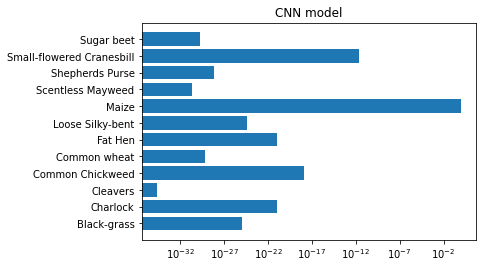

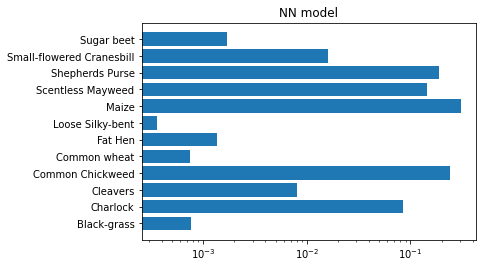

In [229]:
# compare all results
prediction = unFreezeCNN.predict(testset)
# CNN model
classIndex = np.argmax(prediction>0.5)
seedling = list(trainset.class_indices.keys())[classIndex]
plt.figure();
plt.title('CNN model');
plt.barh(list(trainset.class_indices.keys()),prediction[0],log=True);

prediction = refineNN.predict(testset)
# NN Model
classIndex = np.argmax(prediction)
seedling = list(trainset.class_indices.keys())[classIndex]
plt.figure();
plt.title('NN model');
plt.barh(list(trainset.class_indices.keys()),prediction[0],log=True);

print("linear regression validation accuracy",lm.score(valX, valY))
print("Lasso model validation accuracy",rm.score(valX, valY))
print("Ridge model validation accuracy",lsm.score(valX, valY))
print("support vector regression validation accuracy",svrm.score(valX, valY))

it is evident that the CNN model outperforms all models<br>
this is advantage of the following key points<br>
1) imagenet learned weights - transfer learning<br>
2) convolutions has more sense of spatial corelation<br>
3) this resnet50 is 175 layer deep by itself<br>

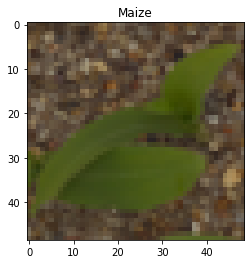

In [230]:
# predict using CNN
prediction = unFreezeCNN.predict(testset)
# process the softmax output
classIndex = np.argmax(prediction>0.5)
seedling = list(trainset.class_indices.keys())[classIndex]
# display the result and image
plt.figure();
plt.title(seedling);
plt.imshow(testset.next()[0]);